## Data Augmentation Using Amazon Bedrock for Anomaly Detection

### Overview

End of Line (EOL) testing that involves visual inspection is a critical step in the manufacturing process. The main goal of visual inspection is to detect any defects or irregularities that might have occurred during the manufacturing process. This can include issues like surface imperfections (ex. scratches), incorrect assembly or missing components. Visual inspection can involve both manual and automated inspection. The automated systems use cameras and ML models to perform the visual inspection (i.e., detect anomalies). <br><br>
 
One of the key challenges when training these ML models is the availability of images showing anomalies of the final product. This is understandable because the companies are normally producing anomaly-free products. In other words, the dataset of images with anomalies is small which presents several challenges (ex. data imbalance) that can significantly impact the model’s performance. To overcome this problem, we try to use the latest LLM models to increase the size of the dataset by generating more images with anomalies.<br><br>

The public dataset used in this notebook contains pictures of mobile phones with 3 types of defects (Oil, scratch and Strain). We focus only in this notebook on the scratch type. 
https://github.com/jianzhang96/MSD

3 methods were tested to generate data (i.e. images for mobile phones with scratches) 1/Directly using prompt, 2/Fine-tuning an existing model and 3/Using inpaint and masking API offered by stability diffusion. 

### Initialization

In [136]:
import boto3
import base64
import json
from PIL import Image, ImageDraw
import io
import matplotlib.pyplot as plt
import numpy as np

# encode_image_from_file (source:modify_image.py)
def encode_image_from_file(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8') # returns a base64-encoded string representation of the image

# encode_image_from_memory
# This function is similar to the previous one, but it works with an in-memory image object rather than a file on disk. 
def encode_image_from_memory(image):
    buffered = io.BytesIO()
    image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

In [137]:
# Display images inside the notebook
def display_images(*images, titles=None):
    num_images = len(images)
    if num_images not in [1, 2, 3]:
        raise ValueError("This function expects 1, 2, or 3 images")
    
    fig, axes = plt.subplots(1, num_images, figsize=(7 * num_images, 7))
    
    if num_images == 1:
        axes = [axes]
    elif num_images == 2:
        axes = [axes[0], axes[1]]
    
    default_titles = ['Original Image', 'Generated Image', 'Mask']
    
    if titles is None:
        titles = default_titles[:num_images]
    elif len(titles) != num_images:
        raise ValueError("Number of titles should match the number of images")
    
    for i, (ax, img, title) in enumerate(zip(axes, images, titles)):
        if isinstance(img, str):
            # Assume it's a base64 encoded string
            #print("base64 encoded string")
            img_data = base64.b64decode(img)
            img = Image.open(io.BytesIO(img_data))
        
        if isinstance(img, Image.Image):
            # For PIL Images
            #print("PIL Images")
            if img.mode == 'L' and i == 1 and num_images == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
        elif isinstance(img, np.ndarray):
            # For NumPy arrays
            #print("NumPy arrays")
            if img.ndim == 2 and i == 1 and num_images == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
        else:
            raise TypeError(f"Unsupported image type for image {i+1}: {type(img)}")
        
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
## Test 
# input_image_path = "/Users/ahmeddd/Desktop/ML_TFC/mobile_pics/good/0001_new_dimensions.png"
# input_image = Image.open(input_image_path).convert('RGB')
# display_images(input_image)

In [138]:
# Initialize the Bedrock client
bedrock = boto3.client(
    service_name='bedrock-runtime',
    region_name='us-east-1'  # Replace with your preferred region but double check that the model availability in that region
)

# Path to the input image
input_image_path = "/Users/ahmeddd/Desktop/ML_TFC/mobile_pics/good/0001_new_dimensions.png"

# Encode the input image
base64_image = encode_image_from_file(input_image_path)

### Method 1: Directly using the prompts

In [139]:
# Prepare the request payload
payload = {
    "text_prompts": [
        {"text": "Add scratches to the screen of the mobile phone", "weight": 1},
        {"text": "Keep the rest of the image unchanged", "weight": 1}
    ],
    "init_image": base64_image,
    "image_strength": 0.35,  # Adjust this value to control how much of the original image is preserved
    "steps": 50,
    "seed": 44,
    "cfg_scale": 7.5,
}

# Convert the payload to JSON
body = json.dumps(payload)

# Make the API call to Bedrock
response = bedrock.invoke_model(
    body=body,
    modelId="stability.stable-diffusion-xl-v1",
    contentType="application/json",
    accept="application/json"
)

# Parse the response
response_body = json.loads(response['body'].read())

# The modified image is returned as a base64-encoded string
generated_image_using_prompt = response_body['artifacts'][0]['base64']


#### As shown in the images below, the images generated have extra buttons that do not exist in the original image. 
#### Different parameters have been tuned but the generated images always had more changes than required (ex. buttons disappeared).

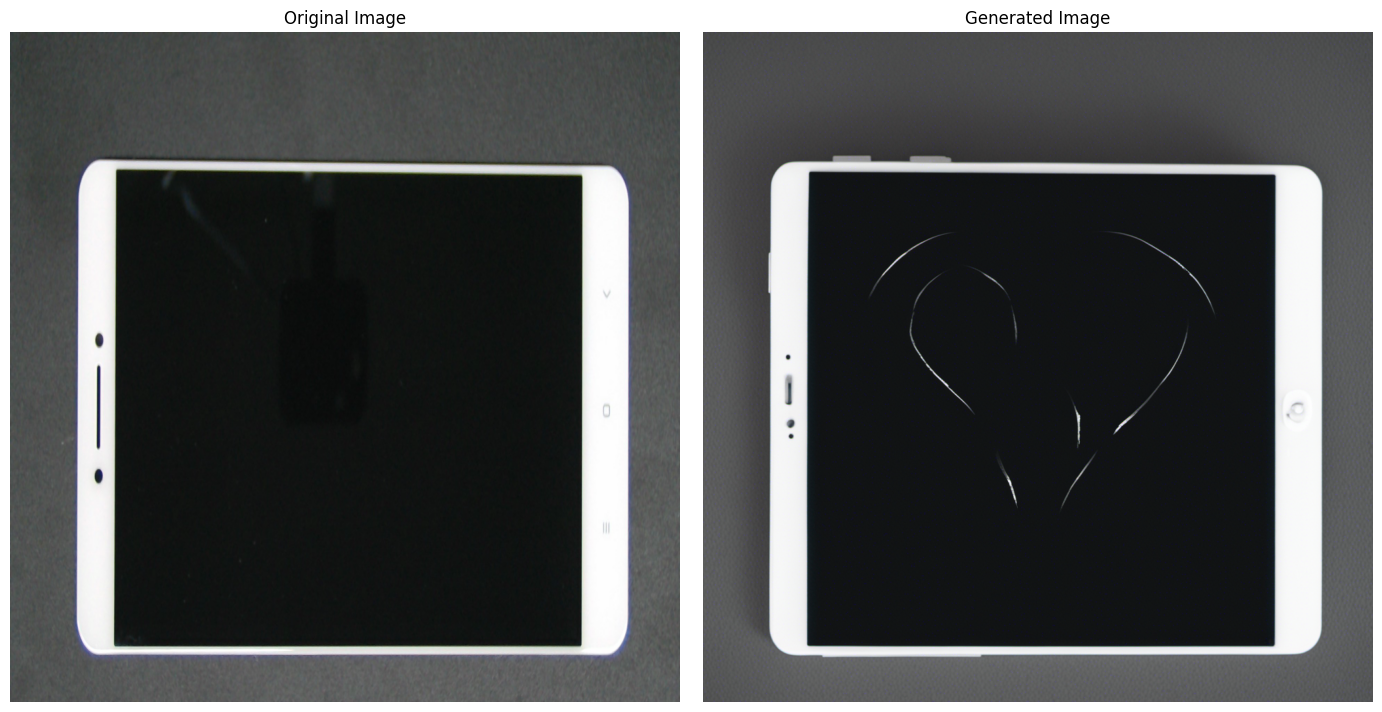

In [140]:
display_images(base64_image,generated_image_using_prompt)

### Method 2: Fine-tuning an existing model

Using this [repo](https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/jumpstart_text_to_image/custom_dog_image_generator.ipynb), 20 images were used to fine-tune a model using Amazon SageMaker Jumpstart. A prompt was then used to generate images using prompts like "A mobile phone with scratches placed in the center of the screen". Although the model was able to generate images for mobile phones with scratch on the screen, the generated images were random. For example, one image had 3 cameras and another one was a bit blurry and zoomed in. This creativity/randomness doesn't help our customers who need relatively consistent data to train models for anomaly detection. 

### Method 3: Inpainting & Masking followed by postprocessing
Inpainting is a technique that allows for selective modification of an image. It involves masking a specific region of the image and then generating new content within that masked area are based on the provided prompt. 

In [141]:
# Open the input image
input_image = Image.open(input_image_path).convert('RGB')

# Create a mask (you'll need to adjust these coordinates to match your image)
mask = Image.new('RGB', input_image.size, (255, 255, 255)) 
draw = ImageDraw.Draw(mask) #creates a drawing object that allows you to draw on the mask image

# Adjust these coordinates to match your phone's screen area
screen_area = [(164, 214), (870, 940)]  # Example coordinates - This is screen coordinates in the picture
draw.rectangle(screen_area, fill=(0, 0, 0))


In [142]:
# Encode the mask image
# base64_image = encode_image_from_memory(input_image)
base64_mask = encode_image_from_memory(mask)

In [143]:
inpaint_prompt = "one scratch on a mobile phone screen" 

payload = {
    "text_prompts":[{"text": inpaint_prompt}],
    "init_image": base64_image,
    "mask_source": "MASK_IMAGE_BLACK",
    "mask_image": base64_mask,
    "cfg_scale": 10, # (Optional) Determines how much the final image portrays the prompt. Use a lower number to increase randomness in the generation.
    "seed": 10,
}

body = json.dumps(payload)

# Make the API call to Bedrock
response = bedrock.invoke_model(
    body=body,
    modelId="stability.stable-diffusion-xl-v1",
    contentType="application/json",
    accept="application/json"
)

response_body = json.loads(response.get("body").read())

generated_image_using_inpaiting_b4_processing = response_body["artifacts"][0].get("base64")

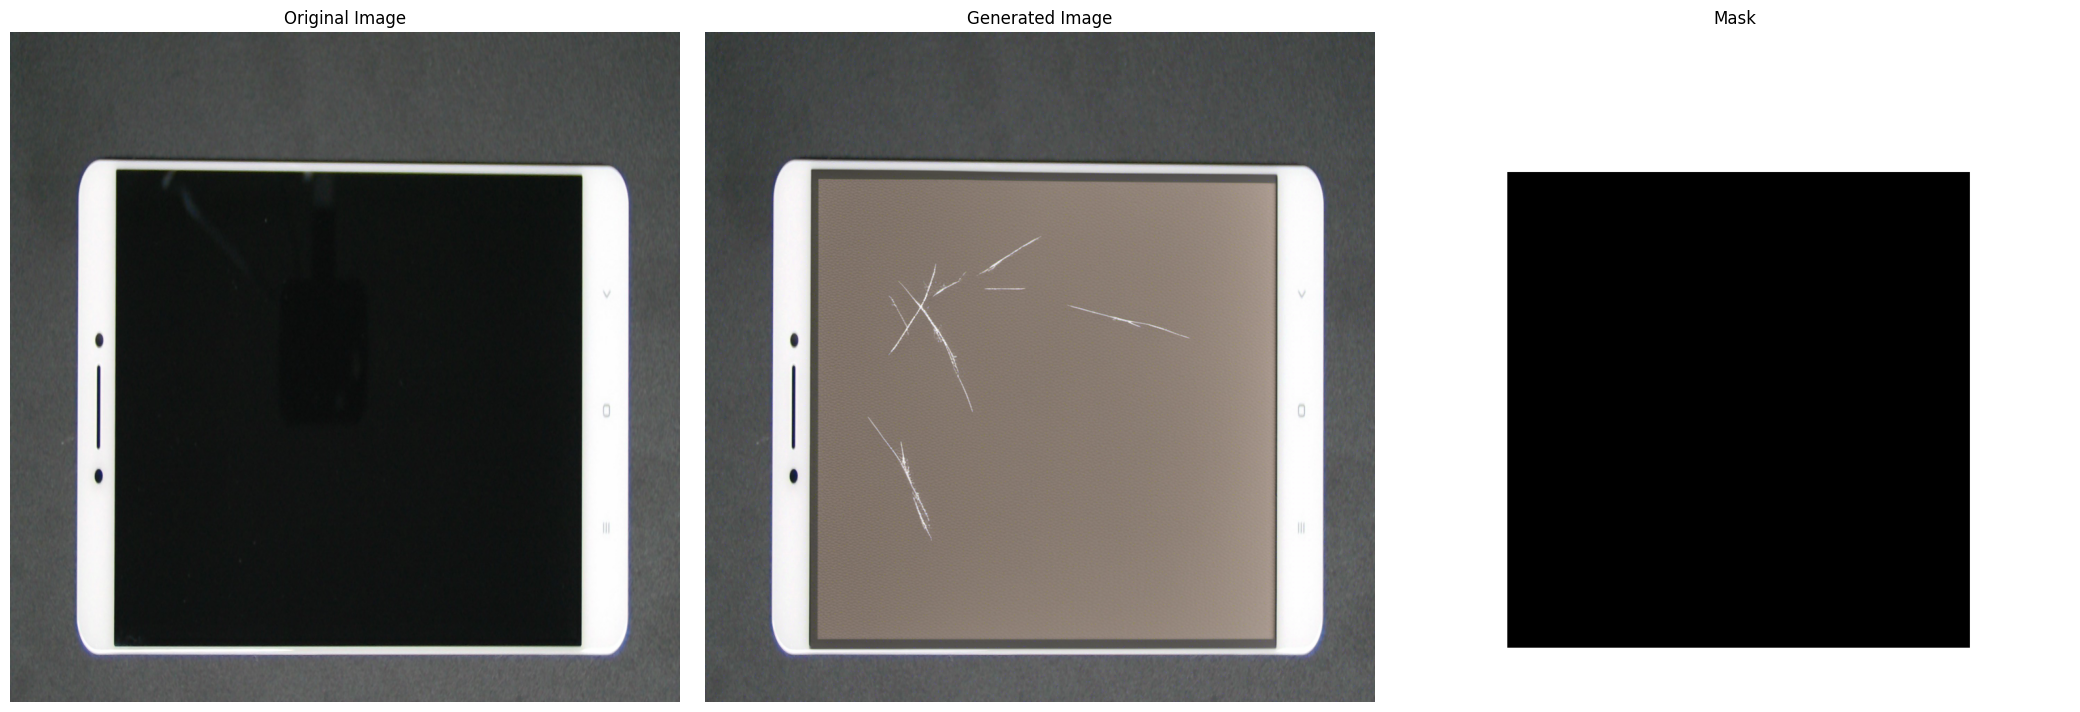

In [144]:
display_images(base64_image, generated_image_using_inpaiting_b4_processing, base64_mask)

### Post Processing
This function processes an image of a mobile device, focusing on the screen area. It converts the screen's content to a black background while preserving and enhancing visible scratches or marks on the screen. 

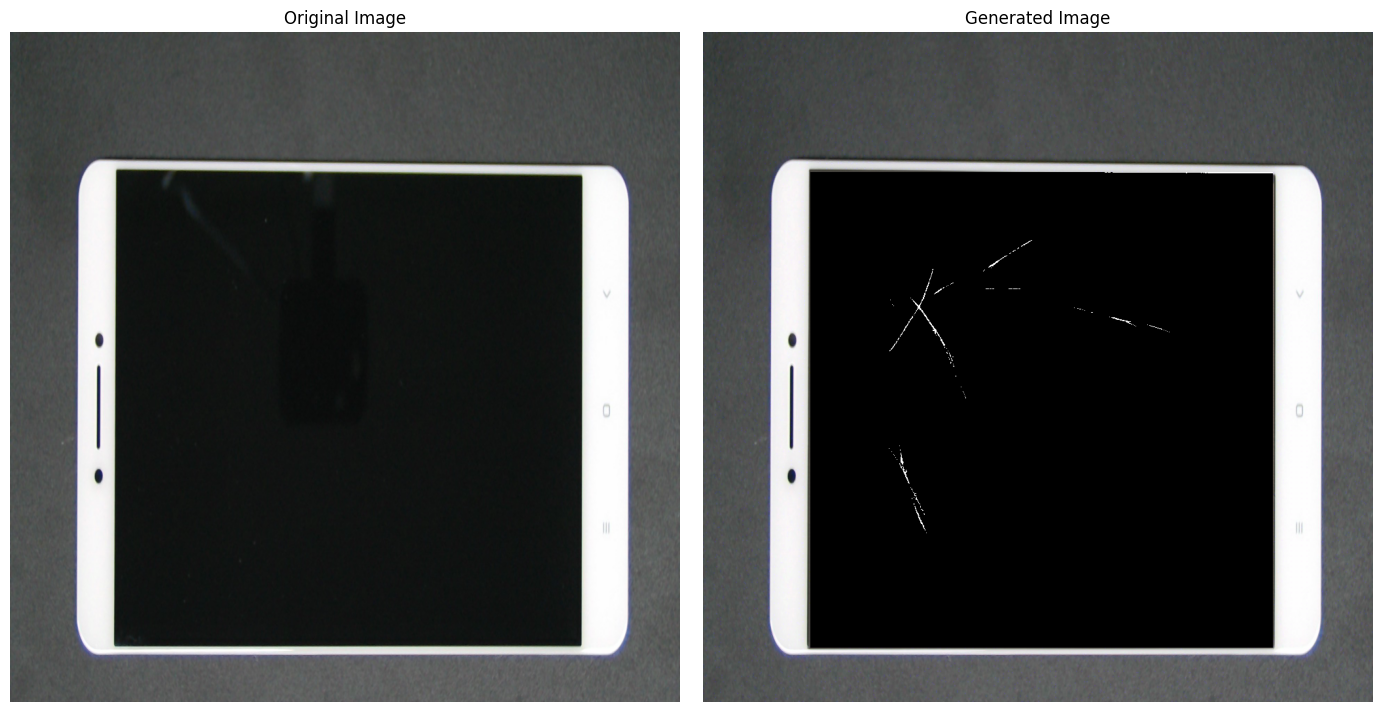

In [145]:
def post_processing(input_base64: str) -> str:
    """
    Change the color of the screen in the image to black while preserving clear scratches.
    
    :param input_base64: str, base64 encoded string of the input image
    :return: str, base64 encoded string of the output image
    """
    # Decode the base64 string to image data
    image_data = base64.b64decode(input_base64)
    img = Image.open(io.BytesIO(image_data))
    
    # Create a mask for the screen area
    mask = Image.new('L', img.size, 0)
    draw = ImageDraw.Draw(mask)
    screen_coords = [(164, 214), (870, 940)]  # Adjust if needed
    draw.rectangle(screen_coords, fill=255)
    
    # Extract the screen area
    screen = Image.new('RGB', img.size, (0, 0, 0))
    screen.paste(img, (0, 0), mask)
    
    # Convert screen to black but keep clear scratches
    screen_data = screen.load()
    width, height = screen.size
    for x in range(width):
        for y in range(height):
            r, g, b = screen_data[x, y]
            brightness = (r + g + b) / 3
            if brightness > 200:  # Only keep very bright pixels as scratches
                screen_data[x, y] = (255, 255, 255)  # Make scratches white for clarity
            else:
                screen_data[x, y] = (0, 0, 0)  # Set to black
    
    # Paste the modified screen back onto the original image
    img.paste(screen, (0, 0), mask)
    
    # Save the result to a bytes buffer
    buffer = io.BytesIO()
    img.save(buffer, format="PNG")
    
    # Encode the image to base64
    output_base64 = base64.b64encode(buffer.getvalue()).decode('utf-8')
    
    return output_base64

generated_image_after_processing = post_processing(generated_image_using_inpaiting_b4_processing)
display_images(base64_image, generated_image_after_processing)